In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-tv-shows-and-movies/credits.csv
/kaggle/input/netflix-tv-shows-and-movies/titles.csv


**Importing libraries**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

**Specify the file paths for both database files**

In [4]:
titles_file_path = "/kaggle/input/netflix-tv-shows-and-movies/titles.csv"
credits_file_path = "/kaggle/input/netflix-tv-shows-and-movies/credits.csv"

**Load the titles dataset**

In [5]:
titles_data = pd.read_csv(titles_file_path)
titles_data.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


**Load the credits dataset**

In [6]:
credits_data = pd.read_csv(credits_file_path)
credits_data.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


**Feature engineering**


**Extracting relevant features from titles_data**

In [7]:
titles_data['description_length'] = titles_data['description'].str.len() 

**Feature engineering on credits_data**

**Counting the number of characters in the 'character' column**

In [8]:
credits_data['character_length'] = credits_data['character'].str.len()

**Merge datasets on a common column (if needed)**

In [9]:
merged_data = pd.merge(titles_data, credits_data, on='id', how='inner')

**Data cleaning and preprocessing**

**Handle missing values**

In [10]:
merged_data.dropna(inplace=True)

**Select relevant features and target variable**

In [11]:
X = merged_data[['description_length', 'character_length', 'release_year', 'runtime', 'genres']]
y = merged_data['imdb_score']

**Data visualization**

**Pairplot of the selected features**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

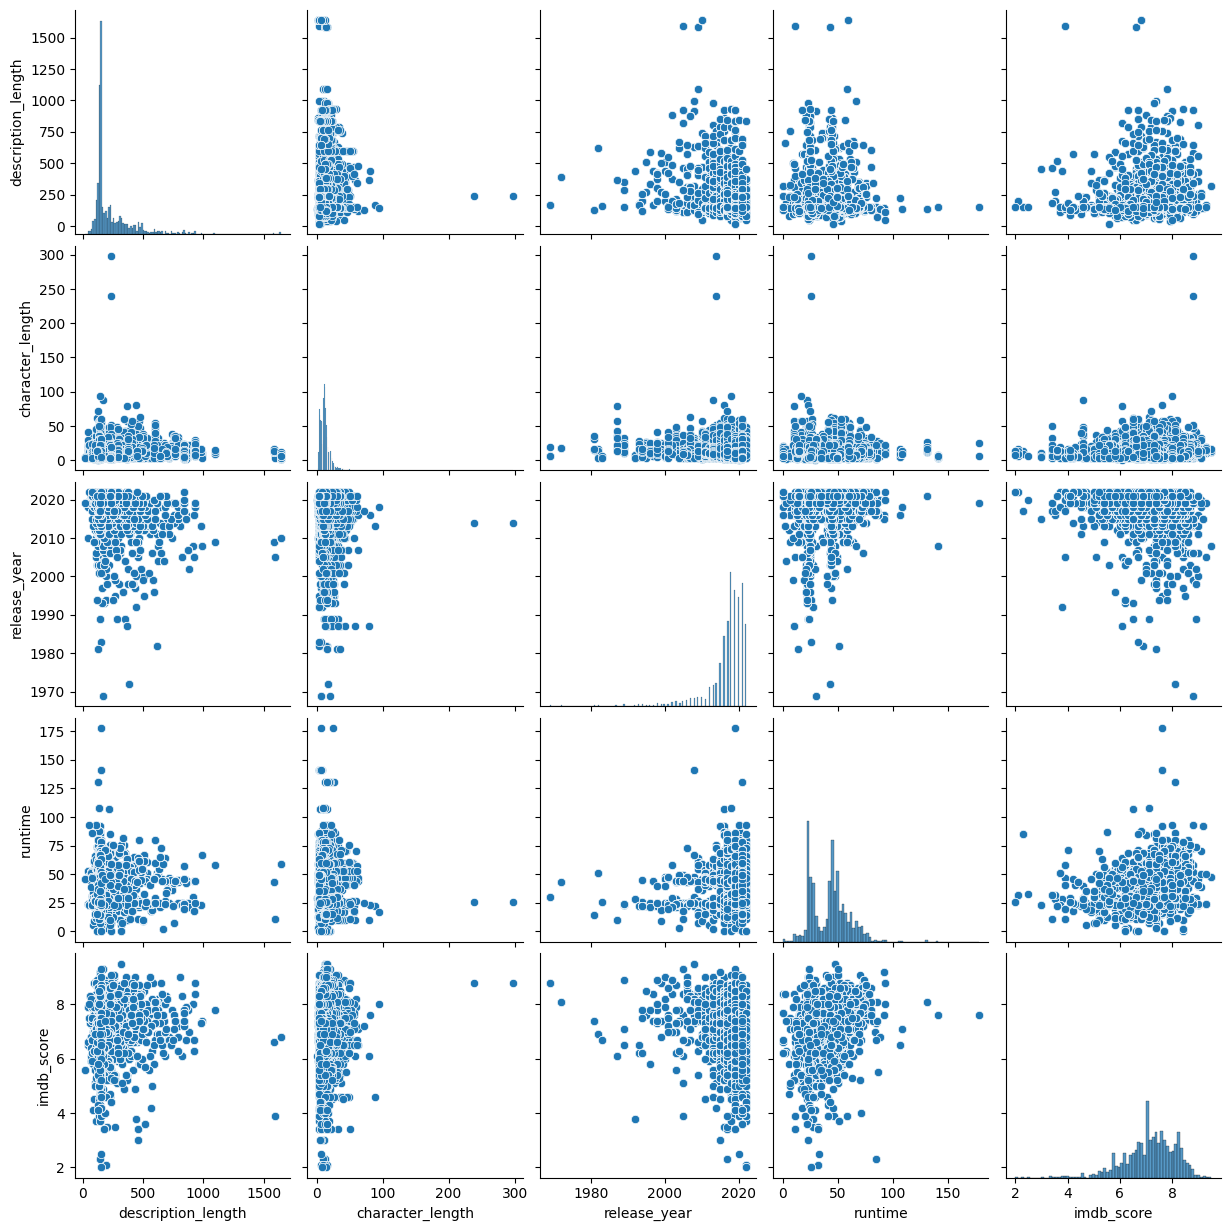

In [12]:
sns.pairplot(merged_data[['description_length', 'character_length', 'release_year', 'runtime', 'imdb_score']])
plt.show()

**Distribution plot of IMDb Score**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


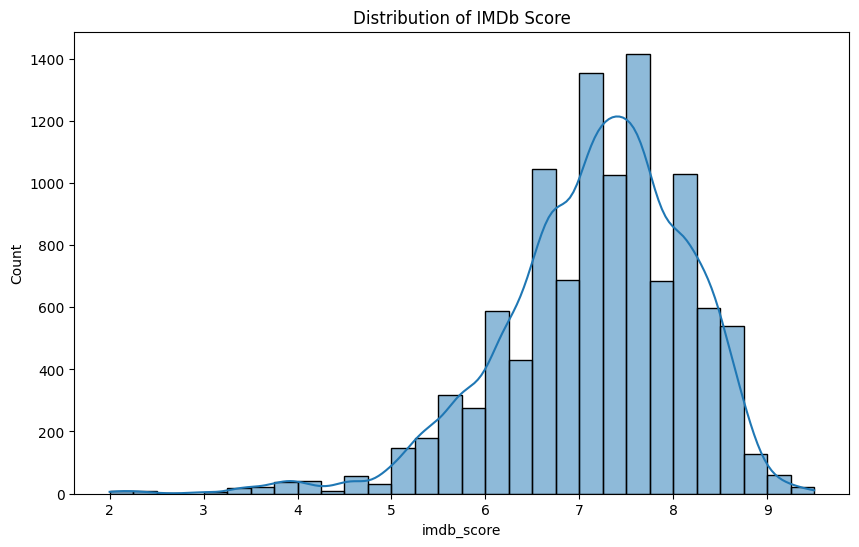

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of IMDb Score')
plt.show()

**Split data into train and test sets**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Preprocessing pipeline**

In [15]:
numeric_features = ['description_length', 'character_length', 'release_year', 'runtime']
categorical_features = ['genres']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

**Define models**

In [16]:
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Linear Regression': LinearRegression()
}

**Train and evaluate models**

In [17]:
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

**Print results**

In [18]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"MSE: {metrics['MSE']:.2f}")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"RMSE: {metrics['RMSE']:.2f}")
    print("---------------------------")

Model: Random Forest
MSE: 0.03
MAE: 0.05
RMSE: 0.17
---------------------------
Model: Linear Regression
MSE: 0.33
MAE: 0.33
RMSE: 0.58
---------------------------


**Hyperparameter tuning (Grid search) for Random Forest**

In [19]:
param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
}

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=42))])
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print("Best MSE score on validation data:", -grid_search.best_score_)

Best parameters found:
{'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 150}
Best MSE score on validation data: 0.04927840790697674


**Evaluate the best model on test data**

In [20]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Performance of best model on test data:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Performance of best model on test data:
MSE: 0.03
MAE: 0.05
RMSE: 0.17
